In [1]:
import datetime
from statistics import mean
from pprint import pprint

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from data import tfrecord_dataset, train_test_split
from train import train_model
from layers import SeluConv3D, SeluDense
from plot import plot_slice, plot_volume_animation
from config import (
    LIDC_SMALL_NEG_TFRECORD,
    LIDC_SMALL_POS_TFRECORD,
    SMALL_PATCH_SHAPE,
    BIG_PATCH_SHAPE,
    SEED,
)

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

In [2]:
neg_x = tfrecord_dataset(LIDC_SMALL_NEG_TFRECORD)
num_neg_samples = sum(1 for _ in neg_x)
print(f"Number of negative samples: {num_neg_samples}")
neg_x

Number of negative samples: 375


<ParallelMapDataset shapes: (None, None, None, None), types: tf.float32>

In [3]:
neg_dataset = tf.data.Dataset.zip((neg_x, neg_x))
assert sum(1 for _ in neg_dataset) == num_neg_samples
neg_dataset

<ZipDataset shapes: ((None, None, None, None), (None, None, None, None)), types: (tf.float32, tf.float32)>

In [4]:
pos_x = tfrecord_dataset(LIDC_SMALL_POS_TFRECORD)
num_pos_samples = sum(1 for _ in pos_x)
print(f"Number of posative samples: {num_pos_samples}")
pos_x

Number of posative samples: 379


<ParallelMapDataset shapes: (None, None, None, None), types: tf.float32>

In [5]:
pos_dataset = tf.data.Dataset.zip((pos_x, pos_x))
assert sum(1 for _ in pos_dataset) == num_pos_samples
pos_dataset

<ZipDataset shapes: ((None, None, None, None), (None, None, None, None)), types: (tf.float32, tf.float32)>

In [6]:
dataset = neg_dataset.concatenate(pos_dataset)
num_samples = num_neg_samples + num_pos_samples
assert sum(1 for _ in dataset) == num_samples
dataset

<ConcatenateDataset shapes: ((None, None, None, None), (None, None, None, None)), types: (tf.float32, tf.float32)>

In [7]:
# Hyperparameters
val_perc = 0.1
batch_size = 16
patience = 30
learning_rate = 1e-5

In [8]:
train_dataset, val_dataset = train_test_split(
    dataset,
    test_perc=val_perc,
    cardinality=num_samples,
)
val_dataset = (
    val_dataset.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset = (
    train_dataset.batch(batch_size)
    .cache()  # must be called before shuffle
    .shuffle(buffer_size=64, reshuffle_each_iteration=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset

<PrefetchDataset shapes: ((None, None, None, None, None), (None, None, None, None, None)), types: (tf.float32, tf.float32)>

In [9]:
encoder = keras.Sequential(
    [
        keras.layers.InputLayer(SMALL_PATCH_SHAPE, name="encoder_input"),
        SeluConv3D(filters=32, kernel_size=3, name="encoder_selu_conv3d_1"),
        keras.layers.MaxPooling3D((1, 2, 2), name="maxpool_1"),
        SeluConv3D(filters=64, kernel_size=3, name="encoder_selu_conv3d_2"),
        keras.layers.MaxPooling3D((1, 2, 2), name="maxpool_2"),
        SeluConv3D(filters=128, kernel_size=3, name="encoder_selu_conv3d_3"),
        keras.layers.MaxPooling3D((1, 2, 2), name="maxpool_3"),
        SeluConv3D(filters=256, kernel_size=3, name="encoder_selu_conv3d_4"),
        keras.layers.MaxPooling3D((1, 2, 2), name="maxpool_4"),
    ],
    name="encoder",
)
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_selu_conv3d_1 (Conv3 (None, 8, 32, 32, 32)     896       
_________________________________________________________________
maxpool_1 (MaxPooling3D)     (None, 8, 16, 16, 32)     0         
_________________________________________________________________
encoder_selu_conv3d_2 (Conv3 (None, 8, 16, 16, 64)     55360     
_________________________________________________________________
maxpool_2 (MaxPooling3D)     (None, 8, 8, 8, 64)       0         
_________________________________________________________________
encoder_selu_conv3d_3 (Conv3 (None, 8, 8, 8, 128)      221312    
_________________________________________________________________
maxpool_3 (MaxPooling3D)     (None, 8, 4, 4, 128)      0         
_________________________________________________________________
encoder_selu_conv3d_4 (Conv3 (None, 8, 4, 4, 256)      8849

In [10]:
decoder = keras.Sequential(
    [
        keras.layers.InputLayer(encoder.output_shape[1:], name="decoder_input"),
        keras.layers.UpSampling3D((1, 2, 2), name="upsampling_1"),
        SeluConv3D(filters=256, kernel_size=3, name="decoder_selu_conv3d_1"),
        keras.layers.UpSampling3D((1, 2, 2), name="upsampling_2"),
        SeluConv3D(filters=128, kernel_size=3, name="decoder_selu_conv3d_2"),
        keras.layers.UpSampling3D((1, 2, 2), name="upsampling_3"),
        SeluConv3D(filters=64, kernel_size=3, name="decoder_selu_conv3d_3"),
        keras.layers.UpSampling3D((1, 2, 2), name="upsampling_4"),
        SeluConv3D(filters=32, kernel_size=3, name="decoder_selu_conv3d_4"),
        keras.layers.Dense(1, activation="sigmoid", name="decoder_final_dense"),
    ],
    name="decoder",
)
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
upsampling_1 (UpSampling3D)  (None, 8, 4, 4, 256)      0         
_________________________________________________________________
decoder_selu_conv3d_1 (Conv3 (None, 8, 4, 4, 256)      1769728   
_________________________________________________________________
upsampling_2 (UpSampling3D)  (None, 8, 8, 8, 256)      0         
_________________________________________________________________
decoder_selu_conv3d_2 (Conv3 (None, 8, 8, 8, 128)      884864    
_________________________________________________________________
upsampling_3 (UpSampling3D)  (None, 8, 16, 16, 128)    0         
_________________________________________________________________
decoder_selu_conv3d_3 (Conv3 (None, 8, 16, 16, 64)     221248    
_________________________________________________________________
upsampling_4 (UpSampling3D)  (None, 8, 32, 32, 64)     0   

In [11]:
autoencoder = keras.Sequential(
    [
        keras.layers.InputLayer(SMALL_PATCH_SHAPE, name="autoencoder_input"),
        encoder,
        decoder,
    ],
    name="autoencoder",
)
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 8, 2, 2, 256)      1162560   
_________________________________________________________________
decoder (Sequential)         (None, 8, 32, 32, 1)      2931201   
Total params: 4,093,761
Trainable params: 4,093,761
Non-trainable params: 0
_________________________________________________________________


In [12]:
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.MeanSquaredError(),
)

In [13]:
start_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_fname = f"models/autoencoder-{start_time}.h5"
log_dir = f"logs/autoencoder-{start_time}"
autoencoder = train_model(
    autoencoder,
    train_dataset,
    val_dataset,
    patience,
    "val_loss",
    model_fname,
    log_dir,
    verbose_training=1,
    verbose_checkpoint=1,
)

Epoch 1/1000
     43/Unknown - 1s 30ms/step - loss: 0.0875
Epoch 00001: val_loss improved from inf to 0.05350, saving model to models/autoencoder-20201118-215834.h5
43/43 [==============================] - 7s 153ms/step - loss: 0.0875 - val_loss: 0.0535
Epoch 2/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0625
Epoch 00002: val_loss improved from 0.05350 to 0.04307, saving model to models/autoencoder-20201118-215834.h5
43/43 [==============================] - 6s 141ms/step - loss: 0.0614 - val_loss: 0.0431
Epoch 3/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0536
Epoch 00003: val_loss improved from 0.04307 to 0.03885, saving model to models/autoencoder-20201118-215834.h5
43/43 [==============================] - 6s 141ms/step - loss: 0.0549 - val_loss: 0.0388
Epoch 4/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0510
Epoch 00004: val_loss improved from 0.03885 to 0.03694, saving model to models/autoencoder-20201118-215834.h5
43/43 [

Epoch 32/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0434
Epoch 00032: val_loss did not improve from 0.02833
43/43 [==============================] - 2s 37ms/step - loss: 0.0436 - val_loss: 0.0284
Epoch 33/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0442
Epoch 00033: val_loss improved from 0.02833 to 0.02817, saving model to models/autoencoder-20201118-215834.h5
43/43 [==============================] - 6s 140ms/step - loss: 0.0436 - val_loss: 0.0282
Epoch 34/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0443
Epoch 00034: val_loss did not improve from 0.02817
43/43 [==============================] - 2s 37ms/step - loss: 0.0435 - val_loss: 0.0282
Epoch 35/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0440
Epoch 00035: val_loss improved from 0.02817 to 0.02806, saving model to models/autoencoder-20201118-215834.h5
43/43 [==============================] - 6s 140ms/step - loss: 0.0434 - val_loss: 0.0281
Epoch 36/100

Epoch 64/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0427
Epoch 00064: val_loss did not improve from 0.02678
43/43 [==============================] - 2s 38ms/step - loss: 0.0422 - val_loss: 0.0270
Epoch 65/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0434
Epoch 00065: val_loss did not improve from 0.02678
43/43 [==============================] - 2s 37ms/step - loss: 0.0427 - val_loss: 0.0269
Epoch 66/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0417
Epoch 00066: val_loss improved from 0.02678 to 0.02673, saving model to models/autoencoder-20201118-215834.h5
43/43 [==============================] - 6s 140ms/step - loss: 0.0420 - val_loss: 0.0267
Epoch 67/1000
43/43 [==============================] - ETA: 0s - loss: 0.0420
Epoch 00067: val_loss improved from 0.02673 to 0.02666, saving model to models/autoencoder-20201118-215834.h5
43/43 [==============================] - 6s 141ms/step - loss: 0.0420 - val_loss: 0.0267
Epoch 68/100

43/43 [==============================] - ETA: 0s - loss: 0.0411
Epoch 00097: val_loss improved from 0.02595 to 0.02591, saving model to models/autoencoder-20201118-215834.h5
43/43 [==============================] - 6s 144ms/step - loss: 0.0411 - val_loss: 0.0259
Epoch 98/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0404
Epoch 00098: val_loss improved from 0.02591 to 0.02590, saving model to models/autoencoder-20201118-215834.h5
43/43 [==============================] - 6s 140ms/step - loss: 0.0411 - val_loss: 0.0259
Epoch 99/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0419
Epoch 00099: val_loss improved from 0.02590 to 0.02590, saving model to models/autoencoder-20201118-215834.h5
43/43 [==============================] - 6s 141ms/step - loss: 0.0410 - val_loss: 0.0259
Epoch 100/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0411
Epoch 00100: val_loss did not improve from 0.02590
43/43 [==============================] - 2s 37ms/step

43/43 [==============================] - 2s 37ms/step - loss: 0.0406 - val_loss: 0.0257
Epoch 131/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0416
Epoch 00131: val_loss did not improve from 0.02550
43/43 [==============================] - 2s 37ms/step - loss: 0.0408 - val_loss: 0.0257
Epoch 132/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0412
Epoch 00132: val_loss improved from 0.02550 to 0.02547, saving model to models/autoencoder-20201118-215834.h5
43/43 [==============================] - 6s 140ms/step - loss: 0.0405 - val_loss: 0.0255
Epoch 133/1000
43/43 [==============================] - ETA: 0s - loss: 0.0404
Epoch 00133: val_loss improved from 0.02547 to 0.02545, saving model to models/autoencoder-20201118-215834.h5
43/43 [==============================] - 6s 141ms/step - loss: 0.0404 - val_loss: 0.0254
Epoch 134/1000
41/43 [===========================>..] - ETA: 0s - loss: 0.0408
Epoch 00134: val_loss improved from 0.02545 to 0.02544, sav

Epoch 164/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0409
Epoch 00164: val_loss did not improve from 0.02516
43/43 [==============================] - 2s 36ms/step - loss: 0.0400 - val_loss: 0.0252
Epoch 165/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0408
Epoch 00165: val_loss improved from 0.02516 to 0.02514, saving model to models/autoencoder-20201118-215834.h5
43/43 [==============================] - 6s 140ms/step - loss: 0.0400 - val_loss: 0.0251
Epoch 166/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0398
Epoch 00166: val_loss did not improve from 0.02514
43/43 [==============================] - 2s 37ms/step - loss: 0.0400 - val_loss: 0.0252
Epoch 167/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0402
Epoch 00167: val_loss did not improve from 0.02514
43/43 [==============================] - 2s 36ms/step - loss: 0.0400 - val_loss: 0.0252
Epoch 168/1000
42/43 [============================>.] - ETA: 0s - lo

42/43 [============================>.] - ETA: 0s - loss: 0.0406
Epoch 00198: val_loss did not improve from 0.02494
43/43 [==============================] - 2s 36ms/step - loss: 0.0398 - val_loss: 0.0250
Epoch 199/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0393
Epoch 00199: val_loss did not improve from 0.02494
43/43 [==============================] - 2s 36ms/step - loss: 0.0397 - val_loss: 0.0250
Epoch 200/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0398
Epoch 00200: val_loss did not improve from 0.02494
43/43 [==============================] - 2s 36ms/step - loss: 0.0396 - val_loss: 0.0250
Epoch 201/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0404
Epoch 00201: val_loss improved from 0.02494 to 0.02493, saving model to models/autoencoder-20201118-215834.h5
43/43 [==============================] - 6s 140ms/step - loss: 0.0396 - val_loss: 0.0249
Epoch 202/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0392
Epoc

42/43 [============================>.] - ETA: 0s - loss: 0.0398
Epoch 00233: val_loss did not improve from 0.02475
43/43 [==============================] - 2s 37ms/step - loss: 0.0393 - val_loss: 0.0248
Epoch 234/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0391
Epoch 00234: val_loss did not improve from 0.02475
43/43 [==============================] - 2s 37ms/step - loss: 0.0393 - val_loss: 0.0248
Epoch 235/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0393
Epoch 00235: val_loss did not improve from 0.02475
43/43 [==============================] - 2s 37ms/step - loss: 0.0393 - val_loss: 0.0248
Epoch 236/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0381
Epoch 00236: val_loss did not improve from 0.02475
43/43 [==============================] - 2s 37ms/step - loss: 0.0393 - val_loss: 0.0248
Epoch 237/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0401
Epoch 00237: val_loss improved from 0.02475 to 0.02473, saving m

Epoch 268/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0399
Epoch 00268: val_loss improved from 0.02462 to 0.02462, saving model to models/autoencoder-20201118-215834.h5
43/43 [==============================] - 6s 140ms/step - loss: 0.0391 - val_loss: 0.0246
Epoch 269/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0386
Epoch 00269: val_loss did not improve from 0.02462
43/43 [==============================] - 2s 37ms/step - loss: 0.0391 - val_loss: 0.0246
Epoch 270/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0388
Epoch 00270: val_loss did not improve from 0.02462
43/43 [==============================] - 2s 37ms/step - loss: 0.0390 - val_loss: 0.0246
Epoch 271/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0399
Epoch 00271: val_loss improved from 0.02462 to 0.02461, saving model to models/autoencoder-20201118-215834.h5
43/43 [==============================] - 6s 140ms/step - loss: 0.0390 - val_loss: 0.0246
Epoch 27

Epoch 304/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0397
Epoch 00304: val_loss improved from 0.02455 to 0.02454, saving model to models/autoencoder-20201118-215834.h5
43/43 [==============================] - 6s 140ms/step - loss: 0.0389 - val_loss: 0.0245
Epoch 305/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0389
Epoch 00305: val_loss did not improve from 0.02454
43/43 [==============================] - 2s 37ms/step - loss: 0.0389 - val_loss: 0.0247
Epoch 306/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0390
Epoch 00306: val_loss did not improve from 0.02454
43/43 [==============================] - 2s 36ms/step - loss: 0.0389 - val_loss: 0.0246
Epoch 307/1000
41/43 [===========================>..] - ETA: 0s - loss: 0.0390
Epoch 00307: val_loss improved from 0.02454 to 0.02453, saving model to models/autoencoder-20201118-215834.h5
43/43 [==============================] - 6s 140ms/step - loss: 0.0388 - val_loss: 0.0245
Epoch 30

41/43 [===========================>..] - ETA: 0s - loss: 0.0387
Epoch 00339: val_loss did not improve from 0.02446
43/43 [==============================] - 2s 37ms/step - loss: 0.0387 - val_loss: 0.0245
Epoch 340/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0395
Epoch 00340: val_loss did not improve from 0.02446
43/43 [==============================] - 2s 37ms/step - loss: 0.0387 - val_loss: 0.0245
Epoch 341/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0394
Epoch 00341: val_loss did not improve from 0.02446
43/43 [==============================] - 2s 37ms/step - loss: 0.0387 - val_loss: 0.0245
Epoch 342/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0385
Epoch 00342: val_loss did not improve from 0.02446
43/43 [==============================] - 2s 36ms/step - loss: 0.0387 - val_loss: 0.0245
Epoch 343/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0383
Epoch 00343: val_loss did not improve from 0.02446
43/43 [======

43/43 [==============================] - 2s 38ms/step - loss: 0.0385 - val_loss: 0.0244
Epoch 376/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0374
Epoch 00376: val_loss did not improve from 0.02441
43/43 [==============================] - 2s 37ms/step - loss: 0.0386 - val_loss: 0.0244
Epoch 377/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0394
Epoch 00377: val_loss did not improve from 0.02441
43/43 [==============================] - 2s 37ms/step - loss: 0.0385 - val_loss: 0.0244
Epoch 378/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0381
Epoch 00378: val_loss did not improve from 0.02441
43/43 [==============================] - 2s 37ms/step - loss: 0.0385 - val_loss: 0.0244
Epoch 379/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0394
Epoch 00379: val_loss did not improve from 0.02441
43/43 [==============================] - 2s 37ms/step - loss: 0.0385 - val_loss: 0.0245
Epoch 380/1000
42/43 [==================

42/43 [============================>.] - ETA: 0s - loss: 0.0391
Epoch 00412: val_loss did not improve from 0.02438
43/43 [==============================] - 2s 37ms/step - loss: 0.0384 - val_loss: 0.0245
Epoch 413/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0380
Epoch 00413: val_loss did not improve from 0.02438
43/43 [==============================] - 2s 37ms/step - loss: 0.0384 - val_loss: 0.0244
Epoch 414/1000
43/43 [==============================] - ETA: 0s - loss: 0.0384
Epoch 00414: val_loss did not improve from 0.02438
43/43 [==============================] - 2s 37ms/step - loss: 0.0384 - val_loss: 0.0244
Epoch 415/1000
41/43 [===========================>..] - ETA: 0s - loss: 0.0383
Epoch 00415: val_loss did not improve from 0.02438
43/43 [==============================] - 2s 37ms/step - loss: 0.0384 - val_loss: 0.0245
Epoch 416/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0390
Epoch 00416: val_loss did not improve from 0.02438
43/43 [======

42/43 [============================>.] - ETA: 0s - loss: 0.0391
Epoch 00449: val_loss did not improve from 0.02434
43/43 [==============================] - 2s 37ms/step - loss: 0.0383 - val_loss: 0.0244
Epoch 450/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0381
Epoch 00450: val_loss did not improve from 0.02434
43/43 [==============================] - 2s 37ms/step - loss: 0.0383 - val_loss: 0.0244
Epoch 451/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0379
Epoch 00451: val_loss did not improve from 0.02434
43/43 [==============================] - 2s 37ms/step - loss: 0.0383 - val_loss: 0.0244
Epoch 452/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0380
Epoch 00452: val_loss did not improve from 0.02434
43/43 [==============================] - 2s 37ms/step - loss: 0.0383 - val_loss: 0.0244
Epoch 453/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0378
Epoch 00453: val_loss did not improve from 0.02434
43/43 [======

42/43 [============================>.] - ETA: 0s - loss: 0.0390
Epoch 00486: val_loss did not improve from 0.02433
43/43 [==============================] - 2s 37ms/step - loss: 0.0382 - val_loss: 0.0244
Epoch 487/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0361
Epoch 00487: val_loss improved from 0.02433 to 0.02431, saving model to models/autoencoder-20201118-215834.h5
43/43 [==============================] - 6s 142ms/step - loss: 0.0381 - val_loss: 0.0243
Epoch 488/1000
43/43 [==============================] - ETA: 0s - loss: 0.0381
Epoch 00488: val_loss did not improve from 0.02431
43/43 [==============================] - 2s 37ms/step - loss: 0.0381 - val_loss: 0.0243
Epoch 489/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0365
Epoch 00489: val_loss did not improve from 0.02431
43/43 [==============================] - 2s 37ms/step - loss: 0.0381 - val_loss: 0.0244
Epoch 490/1000
41/43 [===========================>..] - ETA: 0s - loss: 0.0382
Epoc

Epoch 523/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0388
Epoch 00523: val_loss did not improve from 0.02428
43/43 [==============================] - 2s 37ms/step - loss: 0.0382 - val_loss: 0.0243
Epoch 524/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0375
Epoch 00524: val_loss did not improve from 0.02428
43/43 [==============================] - 2s 37ms/step - loss: 0.0381 - val_loss: 0.0243
Epoch 525/1000
42/43 [============================>.] - ETA: 0s - loss: 0.0376
Epoch 00525: val_loss improved from 0.02428 to 0.02428, saving model to models/autoencoder-20201118-215834.h5
43/43 [==============================] - 6s 140ms/step - loss: 0.0380 - val_loss: 0.0243
Epoch 526/1000
43/43 [==============================] - ETA: 0s - loss: 0.0380
Epoch 00526: val_loss did not improve from 0.02428
43/43 [==============================] - 2s 38ms/step - loss: 0.0380 - val_loss: 0.0243
Epoch 527/1000
42/43 [============================>.] - ETA: 0s - lo

In [16]:
original, _ = next(iter(val_dataset.unbatch().batch(1).skip(6)))
encoder_out = autoencoder.get_layer("encoder")(original, training=False)
decoder_out = autoencoder.get_layer("decoder")(encoder_out, training=False)
plot_volume_animation(original[0, :])

AssertionError: volume must be [z, y, x, (channels)], where channels is optional. Get (1, 8, 32, 32, 1)

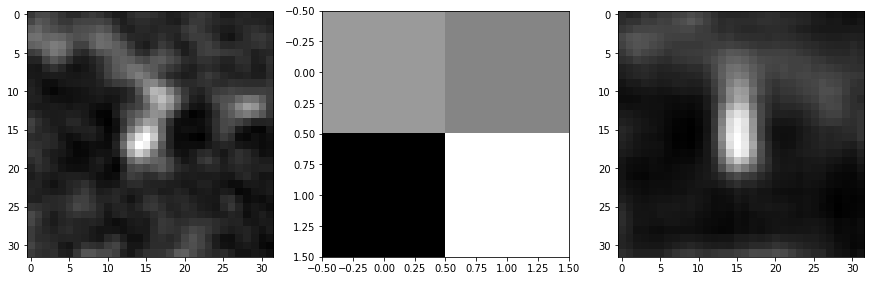

In [49]:
batch_index = 0
z_index = 5
fig, ax = plt.subplots(ncols=3)
plot_slice(original[batch_index, :], index=z_index, ax=ax[0])
plot_slice(encoder_out[batch_index, :], index=z_index, ax=ax[1])
plot_slice(decoder_out[batch_index, :], index=z_index, ax=ax[2])

In [ ]:
plot_animated_volume(original[0, :])